 Simular um sistemas com 1 BS equipada com N antenas, 1 RIS com M elementos e 1 dispositivo com 1 antena. Retornar a SNR no Usuário [Pn = -80 dBm (Potência de Ruido)]

 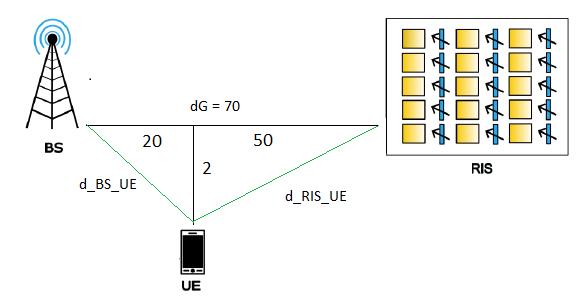


---


 \begin{equation}
\text{SNR} = \left| \left( h_r \cdot T_{\text{diag}} \cdot h_G + h_d \right) \cdot w \right|^2
\end{equation}

representa o **cálculo da relação sinal-ruído (SNR) recebida** em um sistema de comunicação sem fio que utiliza uma **Superfície Inteligente Reconfigurável (RIS)**.

onde

-   $h_r$ → **Canal entre a RIS e o usuário**
    
-   $h_G$ → **Canal entre a BS e a RIS**
    
-   $h_d$ → **Canal direto entre a BS e o usuário**
    
-   $T_{\text{diag}}$ → **Matriz diagonal com os coeficientes da RIS ($\theta$)**
    
-   $w$ → **Vetor de beamforming (ajustado à potência de transmissão $P_t$)**

---

## Geração do vetor beamforming $w$
1.  **Geração das fases aleatórias**
    
    -   As fases ${\theta}$ são sorteadas uniformemente entre $[0, 2\pi]$.
        
    -   O vetor $w$ é construído como $e^{j\theta}$, garantindo que cada elemento tenha módulo 1.
        
2.  **Incorporação da potência de transmissão $P_t$**
    
    -   Multiplicamos por $\sqrt{P_t}$ para refletir a potência total disponível.
        
    -   Normalizamos por $\sqrt{N}$ para garantir que a potência total do vetor seja proporcional a $P_t$.


---
Simular os cenários:
- Sem RIS  
- Com RIS e sem link direto entre BS e Usuário  
- Com RIS e com link direto entre a BS e Usuário  
- Variar algumas configurações do fator de Rice para cada canal (kappa)
- Variar o expoente de perda de percursso para cada canal (alfa)  

---

# Expoente de perda de percurso $\alpha$ (alfa)

| Ambiente                                      | \( $\alpha$ \) |
|----------------------------------------------|-------------|
| Macro células (urbano)                       | 3,5 - 6,5   |
| Micro células (urbano)                       | 2,5 - 3,5   |
| Prédio comercial (mesmo andar)               | 1,5 - 3,5   |
| Prédio comercial (múltiplos andares)         | 2,0 - 6,0   |
| Fábrica                                      | 1,5 - 4,0   |


---
# Fator Rice $\kappa$ (kappa)
| Valor de κ      | Características do Canal                                      |
|----------------|--------------------------------------------------------------|
| κ → 0         | Não há LoS, apenas difusão → **Canal Rayleigh**.             |
| κ ≪ 1         | Pouco LoS, canal ainda muito difuso.                         |
| κ ≫ 1         | LoS dominante, pouca interferência difusa → **Canal próximo ao AWGN puro**. |
| κ → ∞         | Canal puramente LoS (sem dispersão), **ideal para comunicação de alta confiabilidade**. |

---

### **Capacidade R (Shannon)**

A **capacidade do canal** $R$ representa a **máxima taxa de dados (em bits por segundo por Hz)** que pode ser transmitida por um canal de comunicação **sem erro** (teoricamente), **dadas certas condições de ruído e interferência**.

$$
R = B * \log_2\left(1 + {\text{SNR}}\right) \quad \text{[bps/Hz]}
$$

---

## **Decomposição QR**

A **Decomposição QR** (ou **fatoração QR**) é uma técnica da álgebra linear que decompõe uma **matriz $A$** em **duas outras matrizes**:
$$
A = QR
$$

Onde:

-   $Q$: é uma **matriz ortogonal** (ou unitária, no caso de números complexos)  
     Isso quer dizer que $Q^T Q = I$ (transposta de $Q$ vezes $Q$ dá a identidade)
    
-   $R$: é uma **matriz triangular superior**  
     Todos os elementos **abaixo da diagonal principal são zero**

---

##  **SVD (Singular Value Decomposition)**


O **SVD** é uma **fatoração matricial poderosa** que permite decompor qualquer matriz $A \in \mathbb{C}^{m \times n}$ (real ou complexa) em três partes:
$$
A = U \Sigma V^H
$$
Onde:

-   $U \in \mathbb{C}^{m \times m}$: matriz unitária (colunas = autovetores à esquerda),
    
-   $\Sigma \in \mathbb{R}^{m \times n}$: matriz **diagonal** com os **valores singulares** de $A$,
    
-   $V^H \in \mathbb{C}^{n \times n}$: matriz unitária (conjugada transposta de $V$).

---

In [2]:
# Calcula a perda de percurso usando o modelo de log-distância.
def channel_path_loss(PL_CO_lin, d, alpha):
    PL = PL_CO_lin * (d ** -alpha)
    return PL

In [3]:
# Modela o canal de comunicação Rician.
import numpy as np

def channel_model_H(Hlos, Hnlos, kappa, N_realizacao):

    H = []

    for r in range(N_realizacao):
        if kappa == 0:
            H.append(Hnlos[r])  # Apenas o componente NLoS (no caso, Rayleigh)
        else:
            H.append(
                np.sqrt(1 / (1 + kappa)) * Hnlos[r] +
                np.sqrt(kappa / (1 + kappa)) * Hlos[r]
            )  # Modelo Rician

    return H


In [4]:
# Modelo de canal NLoS baseado na distribuição de Rayleigh.
import numpy as np
from scipy.stats import rayleigh

def channel_model_nlos(L, C, N_realizacao):

    Hnlos = []
    pdf1 = rayleigh(scale=1)  # Distribuição de Rayleigh com parâmetro 'b' = 1

    for _ in range(N_realizacao):
        H_real = pdf1.rvs(size=(L, C))  # Parte real do canal
        H_imag = pdf1.rvs(size=(L, C))  # Parte imaginária do canal
        Hnlos.append(H_real + 1j * H_imag)  # Construção do canal complexo

    return Hnlos


In [5]:
#  Modelo de canal LoS
import numpy as np

def channel_model_los(L, C, N_realizacao):

    Hlos = []
    for _ in range(N_realizacao):
        Hlos.append(np.random.randn(L, C) + 1j * np.random.randn(L, C))

    return Hlos


In [6]:
# Converte dBm para mW
def dBm_to_mW(P_dBm):
    return 10 ** (P_dBm / 10)


In [7]:
# Converte dBm para W
def dBm_to_W(P_dBm):
    return 10 ** (P_dBm / 10) / 1000


In [8]:
# Gera vetor beamforming
import numpy as np

def vetor_beamforming(N, Pt):
    # Gera fases aleatórias uniformemente distribuídas entre [0, 2π]
    theta = np.random.uniform(0, 2 * np.pi, N)

    # Calcula o vetor de beamforming com módulo unitário
    w = np.exp(1j * theta).reshape(-1, 1)

    # Garante potência média do vetor igual a Pt
    w = (np.sqrt(Pt) * w) / np.sqrt(N)


    return w

In [10]:
# Main

import numpy as np

# Cenário 1: Somente link direto
# Cenário 2: RIS + link direto
# Cenário 3: Somente RIS

# Configurações de alfa e k para os canais hG, hd e hr - h(k, alfa)
# alfa (Expoente de perda de percurso - α) e kappa (Rician factor - Κ)
configuracoes = [
    {'hG': (20, 1.5), 'hd': (0, 10), 'hr': (20, 1)}
    # {'hG': (0, 6), 'hd': (0, 6), 'hr': (0, 6)},
    # {'hG': (0, 6), 'hd': (0, 6), 'hr': (10, 2)},
    # {'hG': (0, 6), 'hd': (10, 2), 'hr': (0, 6)},
    # {'hG': (0, 6), 'hd': (10, 2), 'hr': (10, 2)},
    # {'hG': (10, 2), 'hd': (0, 6), 'hr': (0, 6)},
    # {'hG': (10, 2), 'hd': (0, 6), 'hr': (10, 2)},
    # {'hG': (10, 2), 'hd': (10, 2), 'hr': (0, 6)},
    # {'hG': (10, 2), 'hd': (10, 2), 'hr': (10, 2)},
    # {'hG': (10, 1), 'hd': (10, 1), 'hr': (10, 1)},
    # {'hG': (10, 2), 'hd': (0, 6.5), 'hr': (10, 2)}
]

#---------------------------- Inicializa variáveis ---------------------------#
# canal hG [BS-RIS]
kappa_hG = 10
alfa_hG = 2

# canal hd [BS-UE]
kappa_hd = 10
alfa_hd = 2

# canal hr [RIS-UE]
kappa_hr = 10
alfa_hr = 2

N_realizacao = 1
M = 20    # Número de elementos da RIS
N = 10 # Número de antenas na BS
PL_C0 = -30 # PL em dB na distância de referência
PL_C0_lin = 10.**(PL_C0/10); # PL linear na distância de referência
Pt = 1000 * (10**-3) # Potência transmitida (1 W)
Pn = -80 # Potência de Ruído em dBm
Pn_lin = (10 ** (Pn / 10)) / (10 ** 3) # Potência de Ruído linear
#-----------------------------------------------------------------------------#

#---------------------  RIS Diagonal [Theta_Diag] ----------------------------#
# Gerando Amp (Matriz de Amplitudes)
Amp = np.random.rand(M, M)  # Valores entre 0 e 1
# Gerando Fase (Matriz de Fases)
Fase = 2 * np.pi / np.random.randint(1, 101, (M, M))
# Calculando Theta (Matriz de Reflexão do RIS)
Theta = Amp * np.exp(-1j * Fase)
# Calculando Theta_Diag (Matriz de Reflexão Diagonal do RIS)
Theta_Diag = np.diag(Theta[:, 0])
# Normalizando Theta_Diag
Theta_Diag /= np.linalg.norm(Theta_Diag)
#-----------------------------------------------------------------------------#

#----------------------- RIS Ortogonal [Theta_Q] -----------------------------#
# Decomposição QR em Theta
Theta_Q, Theta_R = np.linalg.qr(Theta)
#-----------------------------------------------------------------------------#

#------------------------------ Distâncias -----------------------------------#
#                 dG=70
#			      BS<----------->RIS
#              \dv=2|    /
#               \   |   /
#      d_BS_UE   \  |  /   d_RIS_UE
#                 \ | /
#                  \|/
#			        <---->|<---->
#           dG-dr   UE   dr=50
dr = 50  # Distância horizontal entre o RIS e o UE no lado de reflexão
dG = 70  # Distância entre a BS e a RIS
dv = 2   # Distância vertical
d_RIS_UE = np.sqrt(dr**2 + dv**2) # Distância entre a RIS e o Usuário
d_BS_UE = np.sqrt((dG - dr)**2 + dv**2) # Distância entre a BS e o Usuário
#-----------------------------------------------------------------------------#

# print("-------------------------------------------------------------------------------------------------")
# print("Cenário 1: Somente link direto  |  Cenário 2: RIS + link direto  |  Cenário 3: Somente RIS")
# print("-------------------------------------------------------------------------------------------------")
# print(f"hG(k, alfa), hd(k, alfa), hr(k, alfa), Cen1: SNR (dB), Cen2: SNR (dB), Cen3: SNR (dB)")
# print("-------------------------------------------------------------------------------------------------")

print("-----------------------------------------------------------------------------------------------------")
for config in configuracoes:
    kappa_hG, alfa_hG = config['hG']
    kappa_hd, alfa_hd = config['hd']
    kappa_hr, alfa_hr = config['hr']

    #----------------------------------- Path Loss ---------------------------#
    # BS pata RIS
    PL_G = channel_path_loss(PL_C0_lin, dG, alfa_hG);
    # BS para UE
    PL_d = channel_path_loss(PL_C0_lin, d_BS_UE, alfa_hd);
    # RIS para UE
    PL_r = channel_path_loss(PL_C0_lin, d_RIS_UE, alfa_hr);
    #-------------------------------------------------------------------------#

    #----------------------------- Modelo dos Canais -------------------------#
    # hG - Canal BS para RIS
    hG_los = channel_model_los(M, N, N_realizacao)
    hG_nlos = channel_model_nlos(M, N, N_realizacao)
    hG = channel_model_H(hG_los, hG_nlos, kappa_hG, N_realizacao)
    hG[0] = np.sqrt(PL_G) * hG[0]

    # hd - Canal BS para UE
    hd_los = channel_model_los(1, N, N_realizacao)
    hd_nlos = channel_model_nlos(1, N, N_realizacao)
    hd = channel_model_H(hd_los, hd_nlos, kappa_hd, N_realizacao)
    hd[0] = np.sqrt(PL_d) * hd[0]

    # hr - Canal RIS para UE
    hr_los = channel_model_los(1, M, N_realizacao)
    hr_nlos = channel_model_nlos(1, M, N_realizacao)
    hr = channel_model_H(hr_los, hr_nlos, kappa_hr, N_realizacao)
    hr[0] = np.sqrt(PL_r) * hr[0]

    # Vetor Beamforming
    w = vetor_beamforming(N,Pt)
    #-------------------------------------------------------------------------#

    #---------------------  RIS Diagonal [Theta_Diag] ------------------------#
    # Cenário 1: Somente link direto
    # Canal efetivo
    H1 = hd[0] @ w
    # Ganho do canal
    G1 = abs(H1) ** 2

    # Cenário 2: RIS + link direto
    # Canal efetivo
    H2 = (hr[0] @ Theta_Diag @ hG[0] + hd[0]) @ w
    # Ganho do canal
    G2 = abs(H2) ** 2

    # Cenário 3: Somente RIS
    # Canal efetivo
    H3 = (hr[0] @ Theta_Diag @ hG[0]) @ w
    # Ganho do canal
    G3 = abs(H3) ** 2

    # SNR escalar - cenários 1, 2 e 3
    SNR1_escalar = G1.item() * Pt/Pn_lin
    SNR2_escalar = G2.item() * Pt/Pn_lin
    SNR3_escalar = G3.item() * Pt/Pn_lin

    # SNR em dB - cenários 1, 2 e 3
    SNR1_dB = 10 * np.log10(SNR1_escalar)
    SNR2_dB = 10 * np.log10(SNR2_escalar)
    SNR3_dB = 10 * np.log10(SNR3_escalar)

    # Capacidade do canal (B = 1 arbitrário) - cenários 1, 2 e 3
    R1 = 1 * np.log2(1 + SNR1_escalar)
    R2 = 1 * np.log2(1 + SNR2_escalar)
    R3 = 1 * np.log2(1 + SNR3_escalar)

    #------------------------------------------------------------------------#

    #----------------------- RIS Ortogonal [Theta_Q] ------------------------#
    # Cenário 1: Somente link direto
    # Canal efetivo
    H1_Q = hd[0] @ w
    # Ganho do canal
    G1_Q = abs(H1_Q) ** 2

    # Cenário 2: RIS + link direto
    # Canal efetivo
    H2_Q = (hr[0] @ Theta_Q @ hG[0] + hd[0]) @ w
    # Ganho do canal
    G2_Q = abs(H2_Q) ** 2

    # Cenário 3: Somente RIS
    # Canal efetivo
    H3_Q = (hr[0] @ Theta_Q @ hG[0]) @ w
    # Ganho do canal
    G3_Q = abs(H3_Q) ** 2

    # SNR escalar - cenários 1, 2 e 3
    SNR1_Q_escalar = G1_Q.item() * Pt/Pn_lin
    SNR2_Q_escalar = G2_Q.item() * Pt/Pn_lin
    SNR3_Q_escalar = G3_Q.item() * Pt/Pn_lin

    # SNR em dB - cenários 1, 2 e 3
    SNR1_Q_dB = 10 * np.log10(SNR1_Q_escalar)
    SNR2_Q_dB = 10 * np.log10(SNR2_Q_escalar)
    SNR3_Q_dB = 10 * np.log10(SNR3_Q_escalar)

    # Capacidade do canal (B = 1 arbitrário)
    R1_Q = 1 * np.log2(1 + SNR1_Q_escalar)
    R2_Q = 1 * np.log2(1 + SNR2_Q_escalar)
    R3_Q = 1 * np.log2(1 + SNR3_Q_escalar)
    #------------------------------------------------------------------------#

    #---------- RIS SVD (Singular Value Decomposition) [Theta_SVD] ----------#
    # Otimizando a Matriz RIS com SVD
    H_RIS = hr[0] @ hG[0]
    U, S, VH = np.linalg.svd(H_RIS)
    Theta_SVD = np.exp(1j * np.angle(U))

    # Cenário 1: Somente link direto
    # Canal efetivo
    H1_SVD = hd[0] @ w
    # Ganho do canal
    G1_SVD = abs(H1_SVD) ** 2

    # Cenário 2: RIS + link direto
    # Canal efetivo
    H2_SVD = ((hr[0].conj().T @ Theta_SVD).conj().T @ hG[0] + hd[0]) @ w
    # Ganho do canal
    G2_SVD = abs(H2_SVD) ** 2

    # Cenário 3: Somente RIS
    # Canal efetivo
    H3_SVD = ((hr[0].conj().T @ Theta_SVD).conj().T @ hG[0]) @ w
    # Ganho do canal
    G3_SVD = abs(H3_SVD) ** 2

    # SNR escalar - cenários 1, 2 e 3
    SNR1_SVD_escalar = G1_SVD.item() * Pt/Pn_lin
    SNR2_SVD_escalar = G2_SVD.item() * Pt/Pn_lin
    SNR3_SVD_escalar = G3_SVD.item() * Pt/Pn_lin

    # SNR em dB - cenários 1, 2 e 3
    SNR1_SVD_dB = 10 * np.log10(SNR1_SVD_escalar)
    SNR2_SVD_dB = 10 * np.log10(SNR2_SVD_escalar)
    SNR3_SVD_dB = 10 * np.log10(SNR3_SVD_escalar)

    # Capacidade do canal (B = 1 arbitrário)
    R1_SVD = 1 * np.log2(1 + SNR1_SVD_escalar)
    R2_SVD = 1 * np.log2(1 + SNR2_SVD_escalar)
    R3_SVD = 1 * np.log2(1 + SNR3_SVD_escalar)
    #------------------------------------------------------------------------#

    print("|Config dos canais hx(kappa, alfa) - "f"hG({kappa_hG}, {alfa_hG}), hd({kappa_hd}, {alfa_hd}), hr({kappa_hr}, {alfa_hr}) | Cenx: [SNR dB][R bps/Hz]   |")
    print("-----------------------------------------------------------------------------------------------------")
    print("RIS Diagonal")
    print(f"Cen1: [{SNR1_dB:.2f} dB][{R1:.2f} bps/Hz], Cen2: [{SNR2_dB:.2f} dB][{R2:.2f} bps/Hz], Cen3: [{SNR3_dB:.2f} dB][{R3:.2f} bps/Hz]")
    print("-----------------------------------------------------------------------------------------------------")
    print("RIS Ortogonal")
    print(f"Cen1: [{SNR1_Q_dB:.2f} dB][{R1_Q:.2f} bps/Hz], Cen2: [{SNR2_Q_dB:.2f} dB][{R2_Q:.2f} bps/Hz], Cen3: [{SNR3_Q_dB:.2f} dB][{R3_Q:.2f} bps/Hz]")
    print("-----------------------------------------------------------------------------------------------------")
    print("RIS SVD")
    print(f"Cen1: [{SNR1_SVD_dB:.2f} dB][{R1_SVD:.2f} bps/Hz], Cen2: [{SNR2_SVD_dB:.2f} dB][{R2_SVD:.2f} bps/Hz], Cen3: [{SNR3_SVD_dB:.2f} dB][{R3_SVD:.2f} bps/Hz]")
print("-----------------------------------------------------------------------------------------------------")


-----------------------------------------------------------------------------------------------------
|Config dos canais hx(kappa, alfa) - hG(20, 1.5), hd(0, 10), hr(20, 1) | Cenx: [SNR dB][R bps/Hz]   |
-----------------------------------------------------------------------------------------------------
RIS Diagonal
Cen1: [-44.08 dB][0.00 bps/Hz], Cen2: [18.85 dB][6.28 bps/Hz], Cen3: [18.86 dB][6.28 bps/Hz]
-----------------------------------------------------------------------------------------------------
RIS Ortogonal
Cen1: [-44.08 dB][0.00 bps/Hz], Cen2: [29.68 dB][9.86 bps/Hz], Cen3: [29.68 dB][9.86 bps/Hz]
-----------------------------------------------------------------------------------------------------
RIS SVD
Cen1: [-44.08 dB][0.00 bps/Hz], Cen2: [33.00 dB][10.96 bps/Hz], Cen3: [33.00 dB][10.96 bps/Hz]
-----------------------------------------------------------------------------------------------------
